# Test Notebook - RLM_files

This notebook imports from RLM_files folder inside RLM_transformer_training.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Import from RLM_files
import RLM_files.datasets as datasets
import RLM_files.models as models
import RLM_files.init as init
import RLM_files.measures as measures

print(f'datasets from: {datasets.__file__}')

Imports successful!
datasets from: /Users/julialand/Desktop/SISSA_FINAL_RLM/RLM_transformer_training/RLM_files/datasets/__init__.py


In [25]:
# Create RLM
rlm = datasets.RLM(
    v=128,
    L=1,
    beta=2.0,
    seed_rules=12345678,
    seed_samples=56781234,
    num_data=None,
    probs=None,
    transform=None
)

print(f'Analytical RLM entropy: {rlm.entropy:.4f}')
print(f'Analytical RLM marginal: {rlm.marginal:.4f}')
print(f'Log(v): {np.log(rlm.vocab_size)}')

Analytical RLM entropy: 2.9434
Analytical RLM marginal: 4.7674
Log(v): 4.852030263919617


## Compute Empirical Entropy

Verify the analytical entropy by computing it empirically from 100,000 sampled trees.

In [27]:

empirical_stats = rlm.compute_all_empirical_statistics(num_samples=250000)

print(f'\n' + '='*60)
print('COMPARISON: Analytical vs Empirical')
print('='*60)
print(f'Conditional Entropy H(leaf_{{t+1}} | leaf_t):')
print(f'  Analytical: {rlm.entropy:.4f}')
print(f'  Empirical:  {empirical_stats["conditional_entropy"]:.4f}')
print(f'  Difference: {abs(rlm.entropy - empirical_stats["conditional_entropy"]):.4f}')
print(f'\nMarginal Entropy H(leaf_{{t+1}}):')
print(f'  Analytical: {rlm.marginal:.4f}')
print(f'  Empirical:  {empirical_stats["marginal_entropy"]:.4f}')
print(f'  Difference: {abs(rlm.marginal - empirical_stats["marginal_entropy"]):.4f}')


Computing empirical statistics from 250000 samples...
Computing empirical bigram distribution from 250000 samples...
Empirical conditional entropy: 2.9090
Empirical marginal entropy: 4.7734

COMPARISON: Analytical vs Empirical
Conditional Entropy H(leaf_{t+1} | leaf_t):
  Analytical: 2.9434
  Empirical:  2.9090
  Difference: 0.0343

Marginal Entropy H(leaf_{t+1}):
  Analytical: 4.7674
  Empirical:  4.7734
  Difference: 0.0060


In [29]:
# Test sample_batch
inputs, targets = rlm.sample_batch(batch_size=5, L=1)

print(f'inputs shape: {inputs.shape}')
print(f'targets shape: {targets.shape}')
print(f'\ninputs:\n{inputs}')
print(f'\ntargets:\n{targets}')

print(f'\nFor L=1 (depth=1, 2 leaves):')
print(f'  Actual inputs: {inputs.shape}')
print(f'  Actual targets: {targets.shape}')

inputs shape: torch.Size([5, 1])
targets shape: torch.Size([5])

inputs:
tensor([[ 85],
        [  3],
        [105],
        [ 96],
        [ 64]])

targets:
tensor([ 81, 107, 122,  96,  27])

For L=1 (depth=1, 2 leaves):
  Actual inputs: torch.Size([5, 1])
  Actual targets: torch.Size([5])


In [30]:
# Create model
model = models.MLM(
    vocab_size=128,
    block_size=2,
    embedding_dim=128,
    num_heads=4,
    ffwd_size=128,
    num_layers=1,
    dropout=0.0
)

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

Model parameters: 4,293,888


In [ ]:
# Test forward pass
model.eval()
with torch.no_grad():
    outputs = model(inputs)

print(f'outputs shape: {outputs.shape}')


outputs shape: torch.Size([5, 1, 128])
Expected: (5, 1, 128) or (5, 128)


In [32]:
# Test loss
criterion = torch.nn.CrossEntropyLoss()

# Handle output shape
if len(outputs.shape) == 3:
    outputs_for_loss = outputs[:, -1, :]
    print(f'Sliced outputs to: {outputs_for_loss.shape}')
else:
    outputs_for_loss = outputs

loss = criterion(outputs_for_loss, targets)
print(f'\nloss: {loss.item():.4f}')
print(f'Expected ~log(128) = {np.log(128):.4f} for untrained model')

Sliced outputs to: torch.Size([5, 128])

loss: 4.8566
Expected ~log(128) = 4.8520 for untrained model


## Training

In [33]:
import torch.optim as optim

# Training setup
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

num_steps = 5000
batch_size = 64
log_interval = 100

print(f'Training for {num_steps} steps with SGD (lr=1e-3, momentum=0.9)...\n')

losses = []
for step in range(num_steps):
    # Generate batch
    inputs, targets = rlm.sample_batch(batch_size=batch_size, L=1)
    
    # Forward pass
    outputs = model(inputs)
    
    # Handle output shape
    if len(outputs.shape) == 3:
        outputs = outputs[:, -1, :]
    
    loss = criterion(outputs, targets)
    losses.append(loss.item())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Log progress
    if (step + 1) % log_interval == 0:
        avg_loss = sum(losses[-log_interval:]) / log_interval
        print(f'Step {step+1}/{num_steps} | Avg Loss: {avg_loss:.4f}')

print('\nTraining complete!')
print(f'Initial loss: {losses[0]:.4f}')
print(f'Final loss: {losses[-1]:.4f}')
print(f'RLM entropy: {rlm.entropy:.4f}')

Training for 5000 steps with SGD (lr=1e-3, momentum=0.9)...

Step 100/5000 | Avg Loss: 4.7852
Step 200/5000 | Avg Loss: 4.6152
Step 300/5000 | Avg Loss: 4.4366
Step 400/5000 | Avg Loss: 4.2486
Step 500/5000 | Avg Loss: 4.0884
Step 600/5000 | Avg Loss: 3.9435
Step 700/5000 | Avg Loss: 3.8812
Step 800/5000 | Avg Loss: 3.7606
Step 900/5000 | Avg Loss: 3.6900
Step 1000/5000 | Avg Loss: 3.6198
Step 1100/5000 | Avg Loss: 3.5990
Step 1200/5000 | Avg Loss: 3.5381
Step 1300/5000 | Avg Loss: 3.4910
Step 1400/5000 | Avg Loss: 3.4410
Step 1500/5000 | Avg Loss: 3.4500
Step 1600/5000 | Avg Loss: 3.4477
Step 1700/5000 | Avg Loss: 3.3380
Step 1800/5000 | Avg Loss: 3.3853
Step 1900/5000 | Avg Loss: 3.2978
Step 2000/5000 | Avg Loss: 3.3684
Step 2100/5000 | Avg Loss: 3.3781
Step 2200/5000 | Avg Loss: 3.3336
Step 2300/5000 | Avg Loss: 3.3153
Step 2400/5000 | Avg Loss: 3.2759
Step 2500/5000 | Avg Loss: 3.2886
Step 2600/5000 | Avg Loss: 3.2351
Step 2700/5000 | Avg Loss: 3.2864
Step 2800/5000 | Avg Loss: 3.2

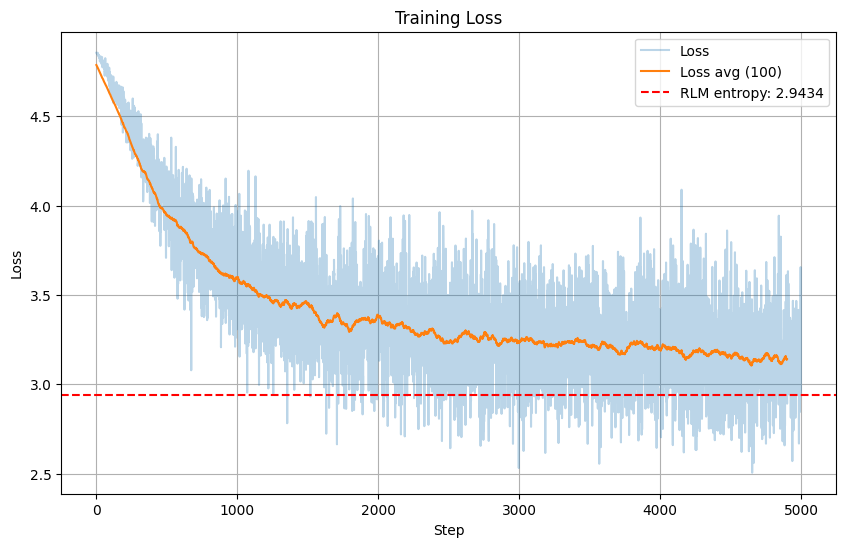

In [35]:
# Plot training curve
plt.figure(figsize=(10, 6))
plt.plot(losses, alpha=0.3, label='Loss')
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'), label='Loss avg (100)')
plt.axhline(y=rlm.entropy, color='r', linestyle='--', label=f'RLM entropy: {rlm.entropy:.4f}')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

## Test Evaluation (Fresh Data)

In [36]:
# Evaluate on FRESH test data (not seen during training)
model.eval()

test_batch_size = 1000
test_inputs, test_targets = rlm.sample_batch(batch_size=test_batch_size, L=1)

print(f'Evaluating on {test_batch_size} FRESH samples...')
print(f'Test inputs shape: {test_inputs.shape}')
print(f'Test targets shape: {test_targets.shape}')

with torch.no_grad():
    outputs = model(test_inputs)
    
    # Handle output shape
    if len(outputs.shape) == 3:
        outputs = outputs[:, -1, :]
    
    # Compute loss
    test_loss = criterion(outputs, test_targets)
    
    # Compute accuracy
    predictions = torch.argmax(outputs, dim=-1)
    accuracy = (predictions == test_targets).float().mean()

print(f'\nTest Results (on fresh data):')
print(f'  Test Loss: {test_loss.item():.4f}')
print(f'  Test Accuracy: {accuracy.item():.4f}')
print(f'  RLM Entropy: {rlm.entropy:.4f}')
print(f'  Gap: {abs(test_loss.item() - rlm.entropy):.4f}')

if test_loss.item() < rlm.entropy + 0.5:
    print('\n✓ Model has learned the distribution well!')
else:
    print('\n✗ Model has not converged to RLM entropy')

Evaluating on 1000 FRESH samples...
Test inputs shape: torch.Size([1000, 1])
Test targets shape: torch.Size([1000])

Test Results (on fresh data):
  Test Loss: 3.1197
  Test Accuracy: 0.2840
  RLM Entropy: 2.9434
  Gap: 0.1763

✓ Model has learned the distribution well!
